## 環境初始化
新增 [gym-anytrading](https://github.com/AminHP/gym-anytrading) 套件，當作本次任務的環境。

引入需要的套件，並設定隨機參數種子。

In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv

%matplotlib inline


# 設定 seed
torch.manual_seed(1234)
np.random.seed(1234)


## 使用自訂資料集
本次作業同樣使用台積電 (2330) 2010/1月~2022/10月資料作為使用的內容。

In [2]:
STOCKS_TSMC = pd.read_csv('./2330_stock.csv')
STOCKS_TSMC


,Datetime,Shares,Amount,Open,High,Low,Close,Change,Turnover
0,2010-01-04,39511138,2557720928,65.0,65.0,64.0,64.9,0.4,8255.0
1,2010-01-05,38394084,2464115096,65.0,65.1,63.9,64.5,-0.4,9205.0
2,2010-01-06,52734385,3390698544,64.5,64.9,63.7,64.9,0.4,12597.0
3,2010-01-07,53294614,3437221996,64.9,65.0,64.2,64.2,-0.7,11195.0
4,2010-01-08,48047497,3068341466,63.5,64.3,63.5,64.0,-0.2,9804.0
...,...,...,...,...,...,...,...,...,...
3143,2022-10-13,43158592,17239718998,400.5,403.0,395.0,395.0,-2.5,66846.0
3144,2022-10-14,59841064,24714069328,414.5,416.0,409.0,412.0,17.0,54666.0
3145,2022-10-17,45038159,17954868983,400.0,403.5,396.0,397.0,-15.0,66589.0
3146,2022-10-18,41304834,16675510801,406.5,407.0,399.5,407.0,10.0,30538.0


將台積電資料輸入股票環境，並設定本次環境範圍與輸入天數資料 (欄位內容、天數等)。


In [3]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    # 這邊可修改想要使用的 feature
    signal_features = env.df.loc[:, ['Close', 'Open']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    # 除 _process_data 外，其餘功能 (class function) 禁止覆寫
    _process_data = my_process_data


# window_size: 能夠看到幾天的資料當作輸入, frame_bound: 想要使用的資料日期區間
# 可修改 frame_bound 來學習不同的環境資料
# 不可修改此處 window_size 參數
env = MyStocksEnv(df=STOCKS_TSMC, window_size=10, frame_bound=(1000, 1500))


檢視環境參數

env information:
> shape: (10, 2)
> df.shape: (3148, 9)
> prices.shape: (510,)
> signal_features.shape: (510, 2)
> max_possible_profit: 13.477262444760823


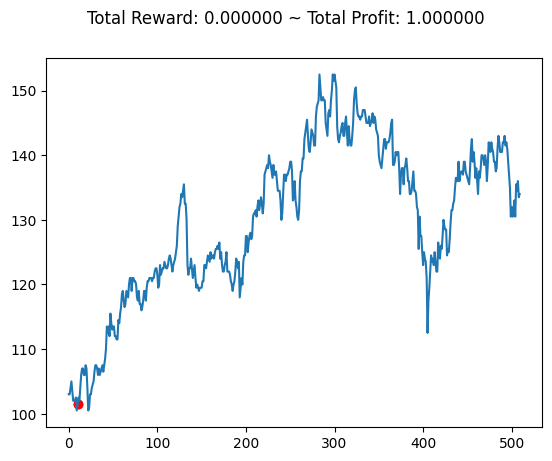

In [4]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())

env.reset()
env.render()


{'total_reward': 60.5, 'total_profit': 0.2505811521765169, 'position': 1}


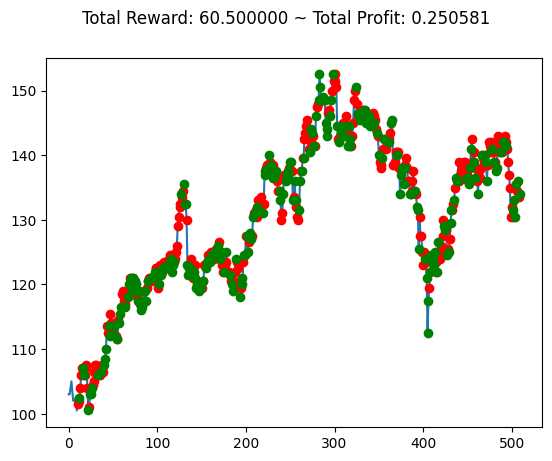

In [5]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print(info)
        break
plt.cla()
env.render_all()
plt.show()


## Actor-Critic


輸入是 20-dim (10天*2欄位)，輸出則是離散的二個動作之一 (賣=0 或 買=1)

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x): # input state, output prob of action
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=32):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x): # input state, output score
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

class ACAgent():
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.9):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.opt = optim.Adam([{"params":self.actor.parameters()}, {"params":self.critic.parameters()}],lr=lr)
        self.gamma = gamma
        # records
        self.log_prob = []
        self.score = []
        self.reward = []

    def recode(self, log_prob:torch.Tensor, score:torch.Tensor, reward:torch.Tensor):
        self.log_prob.append(log_prob)
        self.score.append(score)
        self.reward.append(reward)

    def sample_action(self, state):
        action_prob = self.actor(state)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.detach().item(), log_prob

    def evaluate_score(self, state):
        return self.critic(state)[0]

    def learn(self):
        # calculating discounted rewards
        rewards = []
        dis_reward = 0
        for reward in self.reward[::-1]:
            dis_reward = reward + self.gamma * dis_reward
            rewards.insert(0, dis_reward) 
        # normalizing the rewards
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-9)
        # counting the loss
        loss = 0
        for log_prob, score, reward in zip(self.log_prob, self.score, rewards):
            advantage = reward - score.item()
            action_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(score, reward)
            loss += (action_loss + value_loss)
        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(list(self.actor.parameters())+list(self.critic.parameters()), 0.5)
        self.opt.step()

    def clear_memory(self):
        del self.log_prob[:]
        del self.score[:]
        del self.reward[:]

    def load_ckpt(self, ckpt_path):
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            self.actor.load_state_dict(checkpoint['actor_state_dict'])
            self.critic.load_state_dict(checkpoint['critic_state_dict'])
            self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            print("Checkpoint file not found, use default settings")

    def save_ckpt(self, ckpt_path):
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
        }, ckpt_path)


再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [7]:
agent = ACAgent(env.shape[0]*env.shape[1], 2)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在資料日期區間結束後，回放這些「記憶」來訓練 policy network。

In [8]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 200     # 總共更新 400 次
CHECKPOINT_PATH = './model.ckpt'  # agent model 儲存位置

avg_total_rewards = []

agent.actor.train()  # 訓練前，先確保 network 處在 training 模式
agent.critic.train()

prg_bar = tqdm(range(NUM_BATCH), miniters=1)
for batch in prg_bar:
    total_rewards = []
    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        state = torch.FloatTensor(state).flatten()
        done = False
        while not done:
            action, log_prob = agent.sample_action(state)
            score = agent.evaluate_score(state)
            next_state, reward, done, info = env.step(action)

            if reward < 0:
                reward -= 10
            # if reward == 0:
            #     reward -= 0.1
            # if reward > 1:
            #     reward *= reward
            # elif reward > 0:
            #     reward += 5

            agent.recode(log_prob,score,reward)
            state = torch.FloatTensor(next_state).flatten()

        total_rewards.append(info['total_reward'])
    # 更新網路
    agent.learn()
    agent.clear_memory()

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_total_rewards.append(avg_total_reward)
    prg_bar.set_description(f"Average Reward: {avg_total_reward: 04.2f}, Final Reward: {info['total_reward']: 04.2f}, Final Profit: {info['total_profit']: 04.2f}")

# 儲存 agent model 參數
agent.save_ckpt(CHECKPOINT_PATH)


  0%|          | 0/200 [00:00<?, ?it/s]

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升。
若將其畫出來則結果如下：

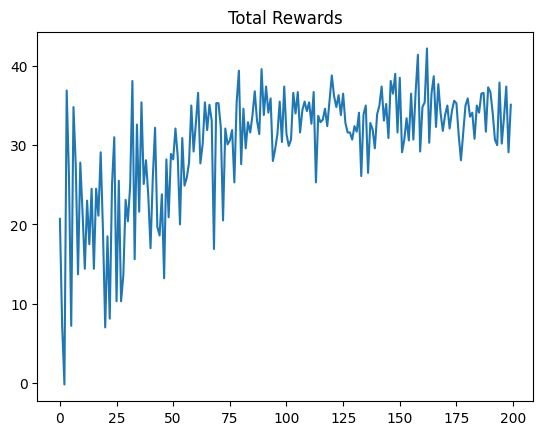

In [9]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

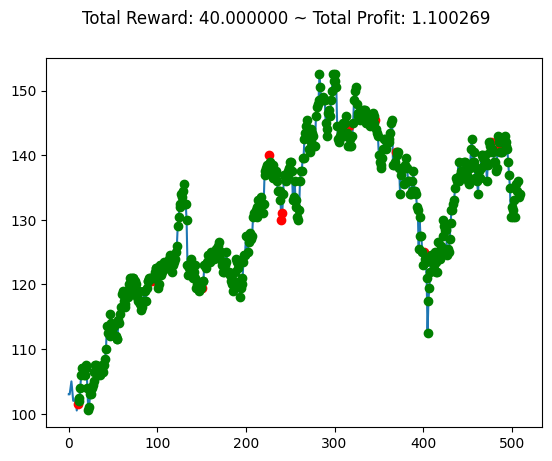

In [10]:
plt.cla()
env.render_all()
plt.show()

## 測試
在這邊我們替換環境使用的資料日期區間，並使用讀取紀錄點的方式來執行測試。

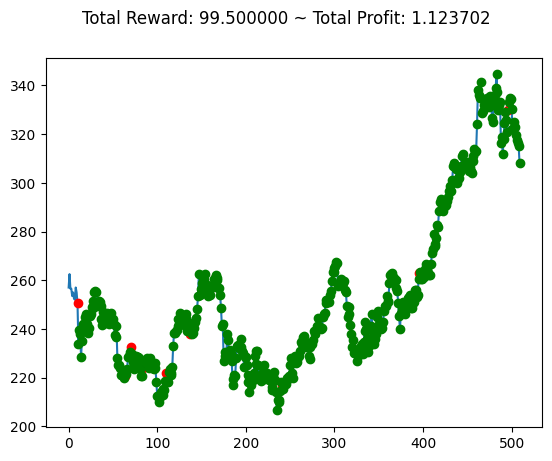

In [11]:

testenv = MyStocksEnv(df=STOCKS_TSMC, window_size=10, frame_bound=(2000, 2500))

network = ACAgent(testenv.shape[0]*testenv.shape[1],2)

checkpoint_path = './model.ckpt'

network.load_ckpt(checkpoint_path)
network.actor.eval()  # 測試前先將 network 切換為 evaluation 模式
network.critic.eval()

state = testenv.reset()
state = torch.FloatTensor(state).flatten()
while True:
    action,_ = network.sample_action(state)
    state, reward, done, info = testenv.step(action)
    state = torch.FloatTensor(state).flatten()
    if done:
        break

plt.cla()
testenv.render_all()
plt.show()
# green buy, red sell
